# Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from keras.models import *
!pip install keras-tuner --upgrade
from keras_tuner import Hyperband

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
holidays = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")
sample_submission = pd.read_csv("sample_submission.csv")
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
transactions = pd.read_csv("transactions.csv")

In [ ]:
train.shape

(3000888, 6)

# Fusion des tables

In [ ]:
data = pd.merge(train, stores)
data.shape

(3000888, 10)

In [ ]:
data = pd.merge(data, oil, how = "left")
data.shape

(3000888, 11)

In [ ]:
data = pd.merge(data, transactions, how = "left")
data.shape

(3000888, 12)

# Feature engineering

## Suppression de colonnes

In [ ]:
data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'dcoilwtico', 'transactions'],
      dtype='object')

In [ ]:
data = data.drop(columns = {'onpromotion', 'type', 'cluster'})

In [ ]:
data.head()

,id,date,store_nbr,family,sales,city,state,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,Quito,Pichincha,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,Quito,Pichincha,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,Quito,Pichincha,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,Quito,Pichincha,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,Quito,Pichincha,NaN,NaN


## Gestion des dates de vacances

In [ ]:
holidays['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [ ]:
holidays = holidays.drop(holidays[holidays['transferred'] == True].index)
holidays = holidays.drop(holidays[holidays['type'] == 'Work Day'].index)

In [ ]:
data = pd.merge(data, holidays, on = "date", how = "left")
data.shape

(3052566, 14)

In [ ]:
def find_holidays(df) :

  if df['locale'] == 'National' :
    df['holidays'] = True
  elif df['locale'] == 'Regional' and df['locale_name'] == df['state'] :
    df['holidays'] = True
  elif df['locale'] == 'Local' and df['locale_name'] == df['city'] :
    df['holidays'] = True

  return df

In [ ]:
data['holidays'] = False

In [ ]:
%%time
data = data.apply(lambda x : find_holidays(x), axis = 1)

CPU times: user 3min 25s, sys: 8.41 s, total: 3min 34s
Wall time: 3min 51s


In [ ]:
data['holidays'].value_counts()

False    2798829
True      253737
Name: holidays, dtype: int64

In [ ]:
duplicated = data[data['id'].duplicated()]['id']
tmp = data[data['id'].isin(duplicated)]

In [ ]:
holiday_ids = tmp[tmp['holidays'] == True]['id']

In [ ]:
data.drop_duplicates(subset = 'id', ignore_index = True, inplace = True)

In [ ]:
data.loc[data['id'].isin(holiday_ids), 'holidays'] = True

In [ ]:
data['holidays'].value_counts()

False    2754972
True      245916
Name: holidays, dtype: int64

In [ ]:
data['holidays'] = data['holidays'].astype(int)

In [ ]:
data.shape

(3000888, 15)

In [ ]:
data.drop(columns = {'city', 'type', 'locale', 'locale_name', 'description', 'transferred'}, inplace = True)

## One-hot encoding

### Family

In [ ]:
data['family'].value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

In [ ]:
data['family_'] = None

In [ ]:
data.loc[data['family'].isin(["PREPARED FOODS", "POULTRY", "MEATS", "LIQUOR, WINE, BEER", "GROCERY I", "GROCERY II", "FROZEN FOODS", "EGGS", "DAIRY", "BREAD/BAKERY", "BEVERAGES", "SEAFOOD"]), ['family_']] = "food"
data.loc[data['family'].isin(["HOME APPLIANCES", "LAWN AND GARDEN", "HOME CARE", "HOME AND KITCHEN II", "HOME AND KITCHEN I", "CLEANING"]), ['family_']] = "home"
data.loc[data['family'].isin(["PERSONAL CARE", "LINGERIE", "LADIESWEAR", "BABY CARE", "BEAUTY"]), ['family_']] = "beauty"
data.loc[data['family'].isin(["SCHOOL AND OFFICE SUPPLIES", "MAGAZINES", "BOOKS"]), ['family_']] = "office"
data.loc[data['family'].isin(["AUTOMOTIVE", "PLAYERS AND ELECTRONICS", "PET SUPPLIES", "HARDWARE", "DELI", "CELEBRATION"]), ['family_']] = "others"

In [ ]:
data['family_'].value_counts()

food      1000296
others     545616
home       545616
beauty     454680
office     272808
Name: family_, dtype: int64

In [ ]:
data = pd.concat([data, pd.get_dummies(data['family_'])], axis = 1)
#data.drop(columns = {'family', 'family_'}, inplace = True)

### State

In [ ]:
data['state'].value_counts()

Pichincha                         1055868
Guayas                             611292
Santo Domingo de los Tsachilas     166716
Azuay                              166716
Manabi                             166716
Cotopaxi                           111144
Tungurahua                         111144
Los Rios                           111144
El Oro                             111144
Chimborazo                          55572
Imbabura                            55572
Bolivar                             55572
Pastaza                             55572
Santa Elena                         55572
Loja                                55572
Esmeraldas                          55572
Name: state, dtype: int64

In [ ]:
data['state_'] = None

In [ ]:
data.loc[data['state'].isin(["Esmeraldas", "Imbabura", "Pichincha", "Santo Domingo de los Tsachilas"]), ['state_']] = "north"
data.loc[data['state'].isin(["Pastaza"]), ['state_']] = "east"
data.loc[data['state'].isin(["Loja", "El Oro", "Azuay"]), ['state_']] = "south"
data.loc[data['state'].isin(["Manabi", "Santa Elena", "Guayas"]), ['state_']] = "west"
data.loc[data['state'].isin(["Tungurahua", "Chimborazo", "Los Rios", "Bolivar", "Cotopaxi"]), ['state_']] = "centre"

In [ ]:
data['state_'].value_counts()

north     1333728
west       833580
centre     444576
south      333432
east        55572
Name: state_, dtype: int64

In [ ]:
data = pd.concat([data, pd.get_dummies(data['state_'])], axis = 1)
#data.drop(columns = {'state', 'state_'}, inplace = True)

## Retravail de la date

In [ ]:
%%time
data['date'] = data['date'].apply(pd.to_datetime)

CPU times: user 4min, sys: 939 ms, total: 4min 1s
Wall time: 4min 12s


In [ ]:
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.day_of_week
data['day_name'] = data['date'].dt.day_name()

# Valeurs manquantes

<Axes: >

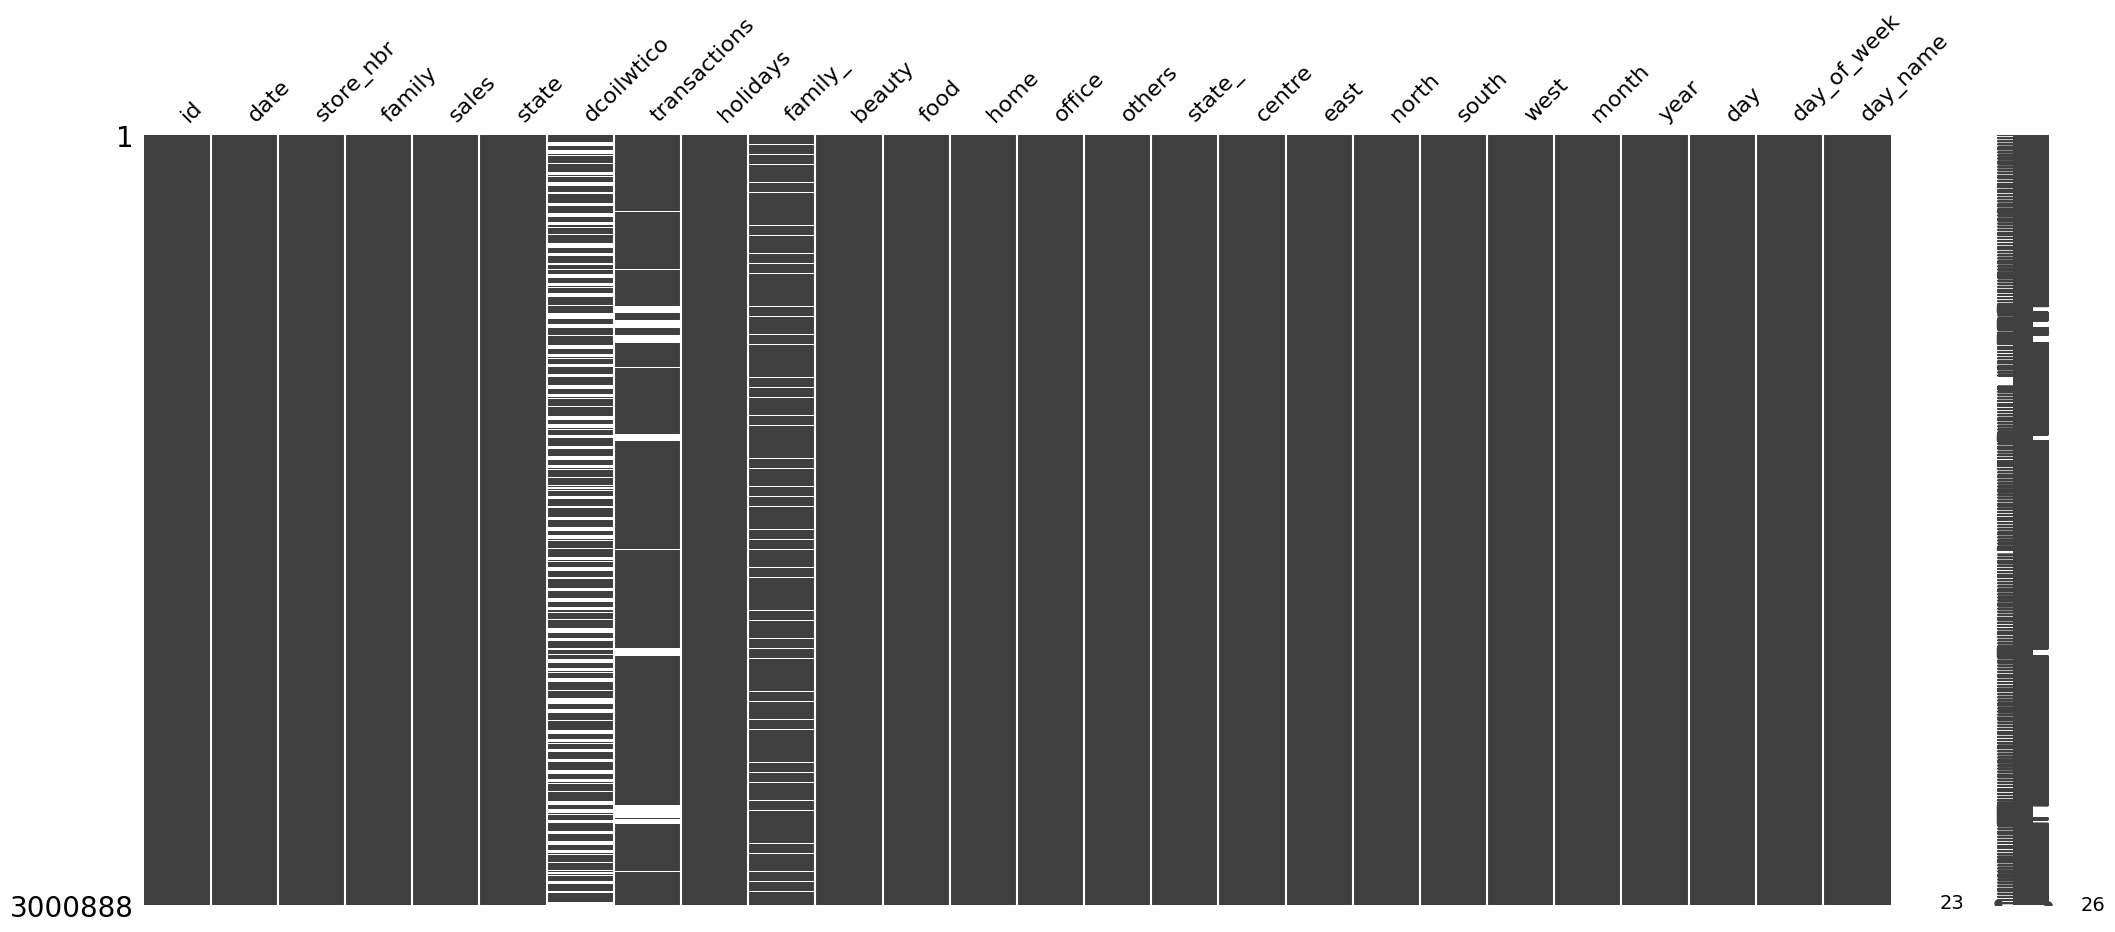

In [ ]:
import missingno as msno
msno.matrix(data)

In [ ]:
data['dcoilwtico'].fillna(data['dcoilwtico'].median(), inplace = True)

In [ ]:
data['transactions'].fillna(0, inplace = True)

<Axes: >

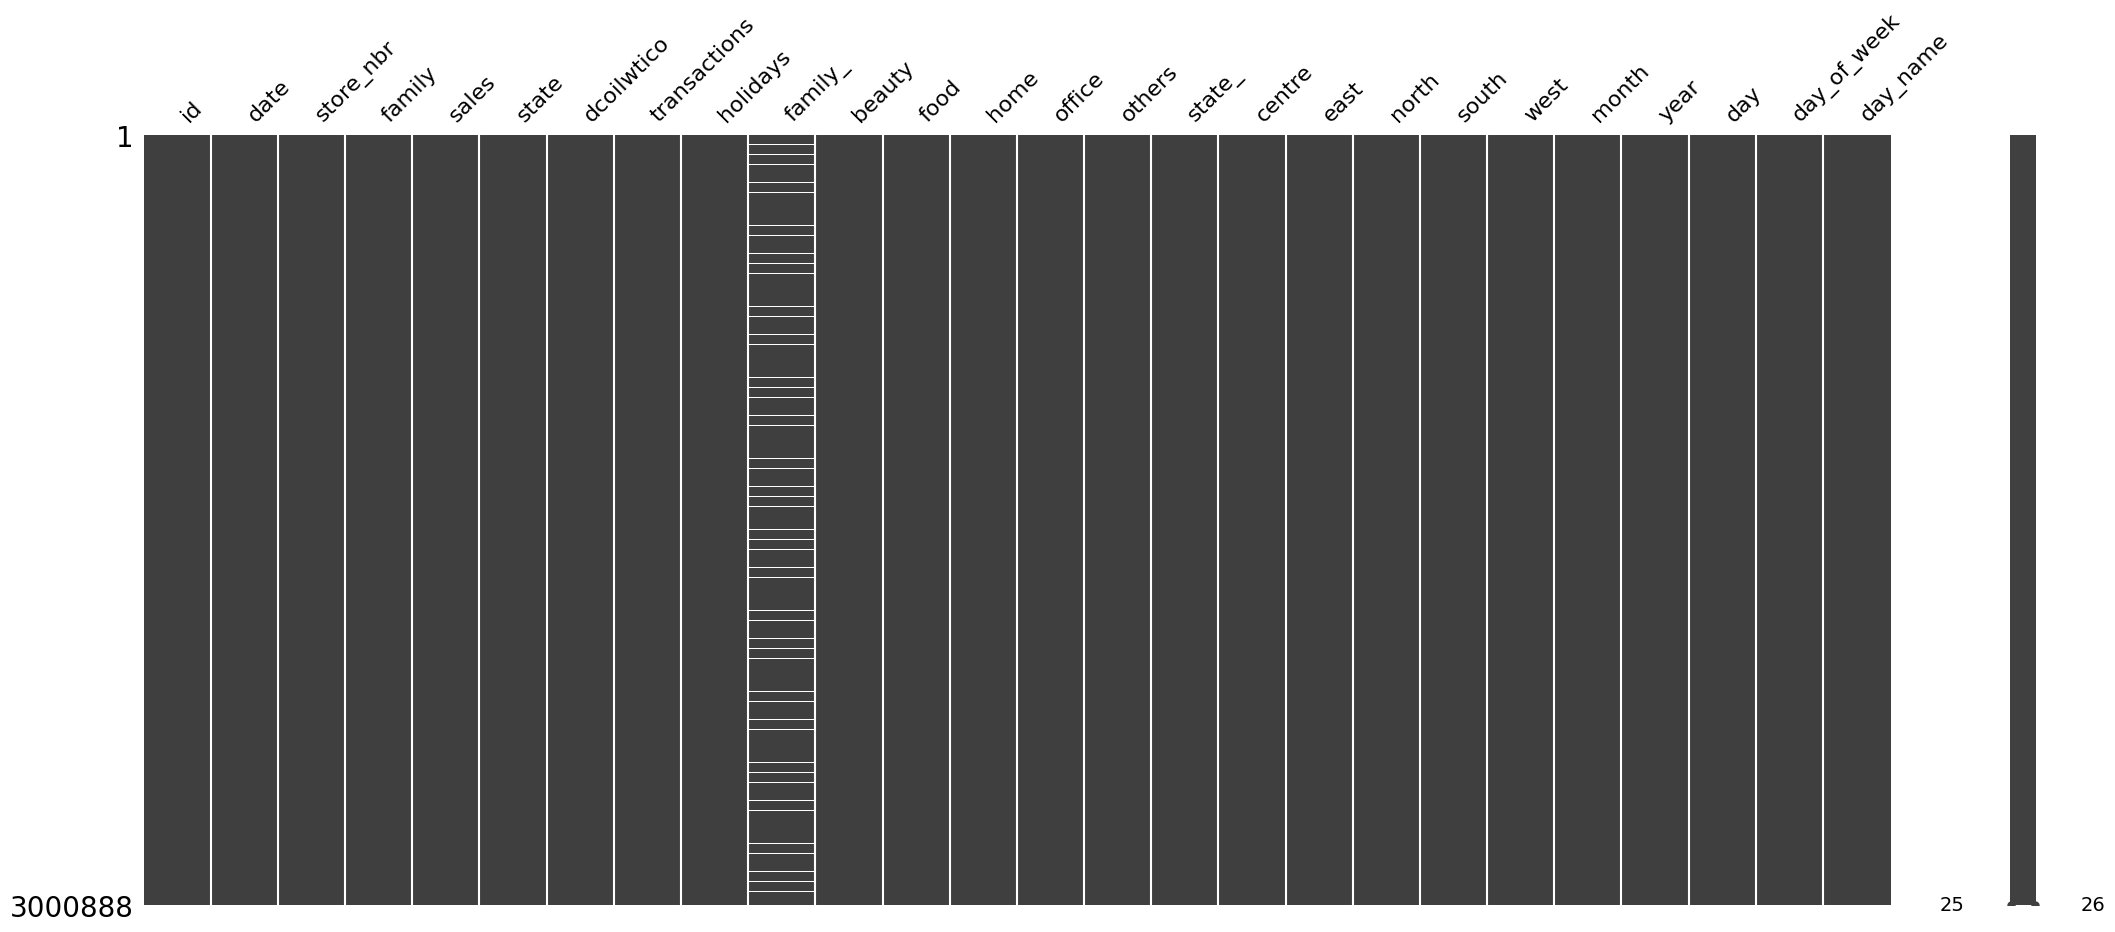

In [ ]:
msno.matrix(data)

# Visualisation

<Axes: xlabel='date', ylabel='sales'>

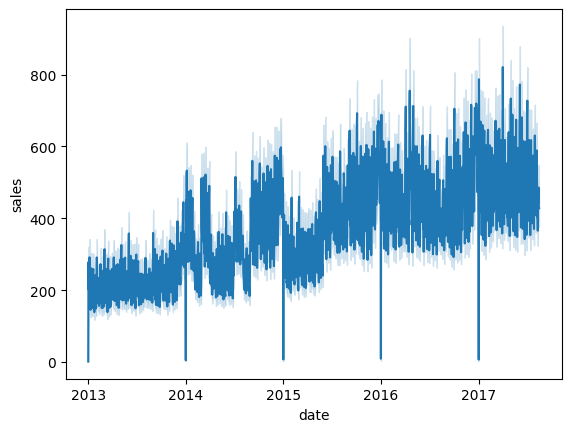

In [ ]:
sns.lineplot(data, x = 'date', y = 'sales')

In [ ]:
def lineplot_sales(grouping_columns, n, m, data = data) :

  fig, axes = plt.subplots(n, m, figsize=(15, 8))
  axes = axes.flatten()

  for ind, column in enumerate(grouping_columns):
      grouped_data = data.groupby(column)['sales'].sum()
      grouped_data = pd.DataFrame(grouped_data).reset_index()

      sns.lineplot(data=grouped_data, x=column, y='sales', ax=axes[ind])

      if type(column) == str :
        plt.xticks(rotation = 90)

  plt.show()

In [ ]:
def pieplot_sales(column, data = data) :

  grouped_data = data.groupby(column)['sales'].sum()

  plt.pie(grouped_data, labels = grouped_data.index, autopct = '%1.f')

  plt.show()

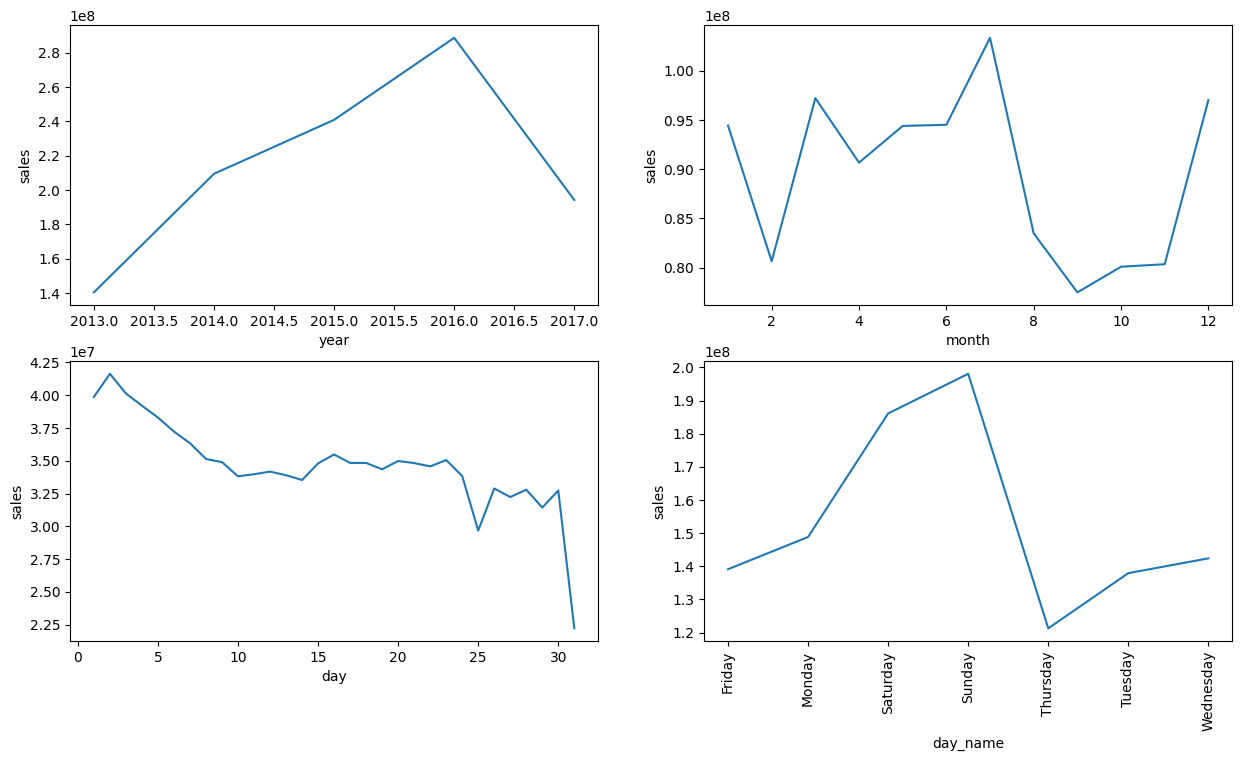

In [ ]:
dates = ['year', 'month', 'day', 'day_name']

lineplot_sales(dates, 2, 2)

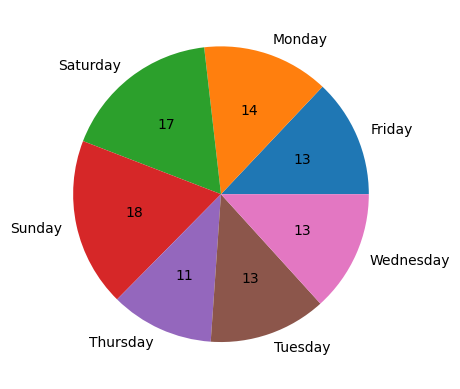

In [ ]:
pieplot_sales(data['day_name'])

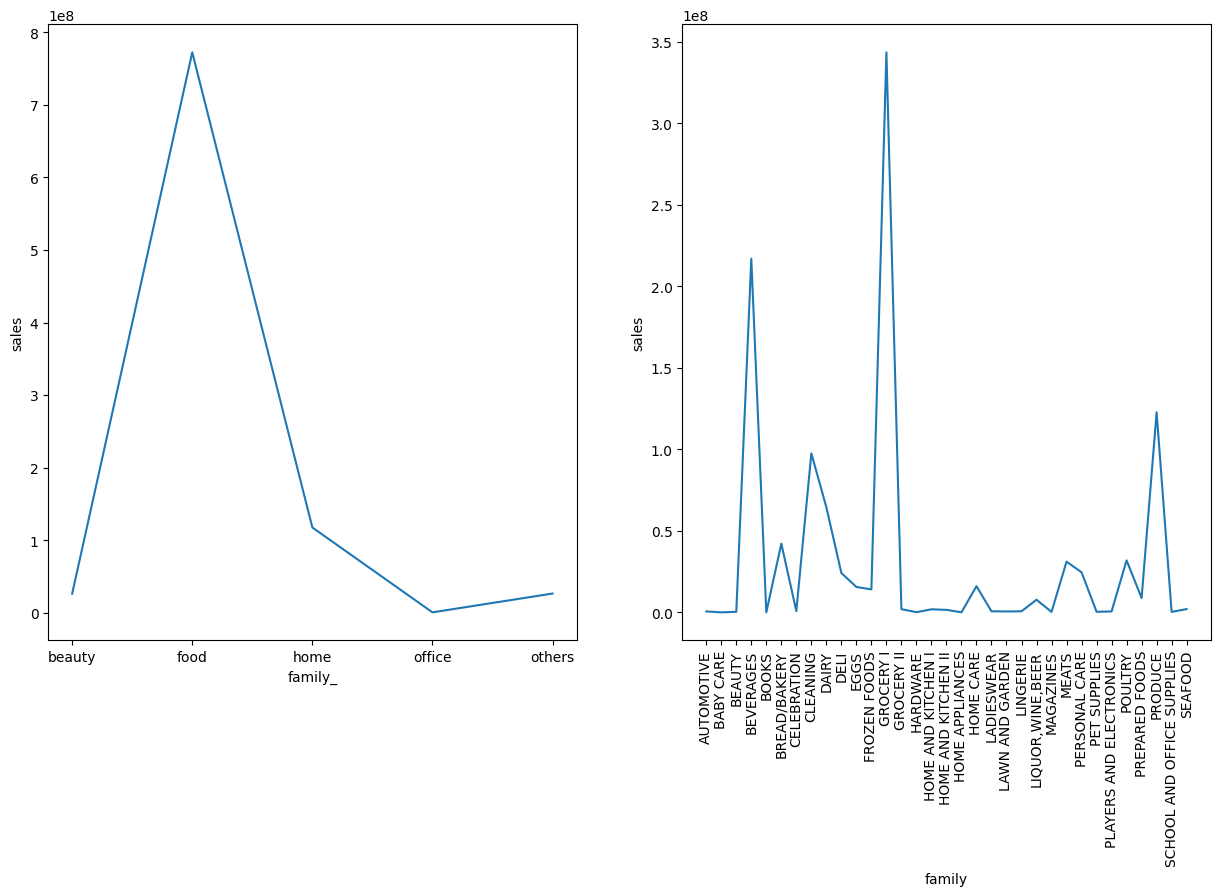

In [ ]:
families = ['family_', 'family']

lineplot_sales(families, 1, 2)

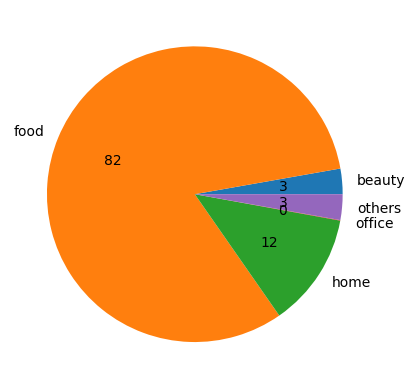

In [ ]:
pieplot_sales(data['family_'])

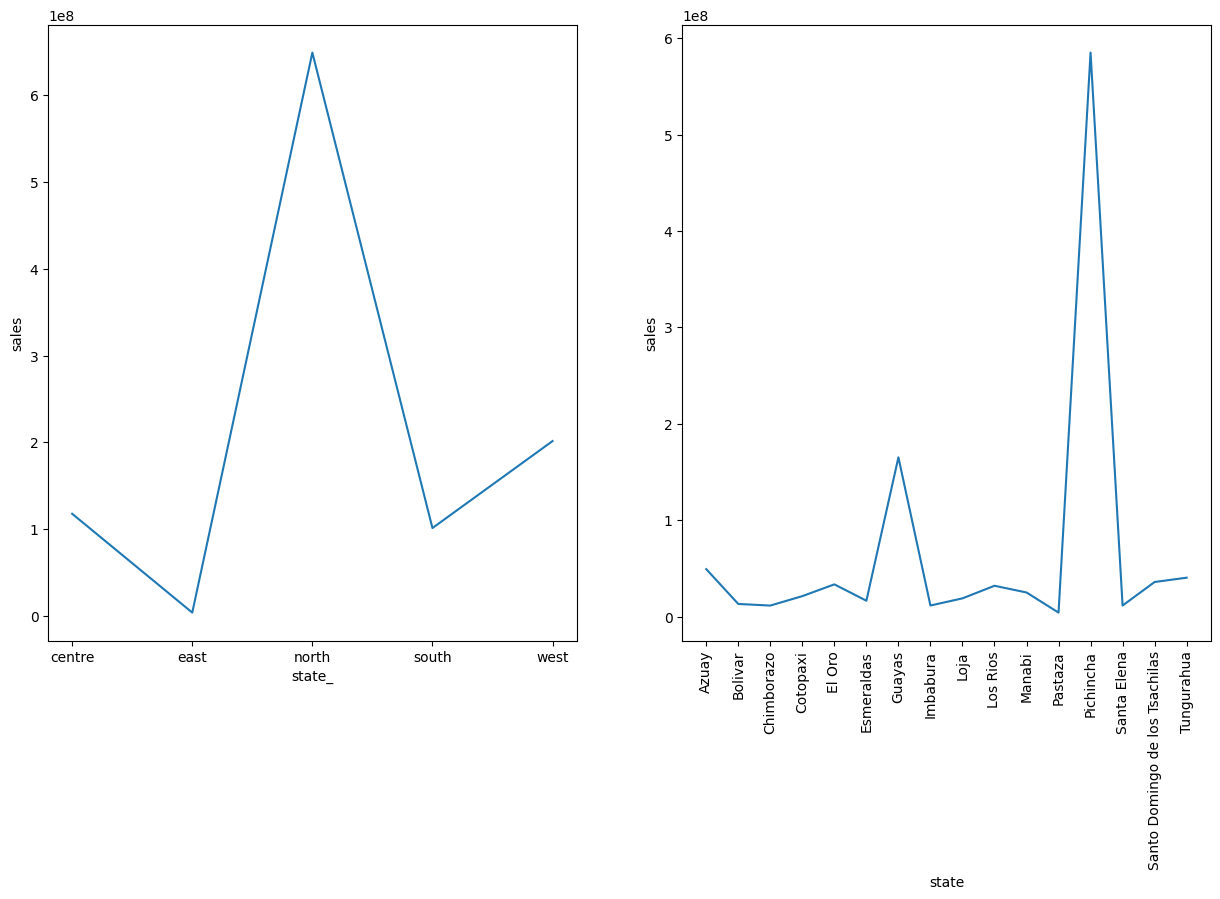

In [ ]:
states = ['state_', 'state']

lineplot_sales(states, 1, 2)

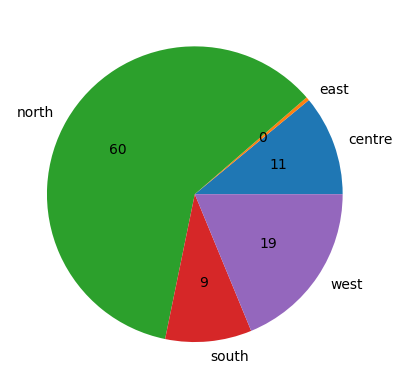

In [ ]:
pieplot_sales(data['state_'])

<Axes: xlabel='store_nbr', ylabel='sales'>

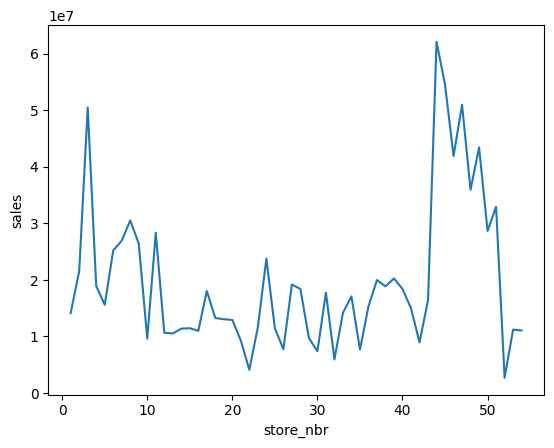

In [ ]:
best_store = data.groupby('store_nbr')['sales'].sum().reset_index()

bs_sorted = best_store.sort_values(by='sales', ascending=False)

sns.lineplot(data=bs_sorted, x='store_nbr', y='sales')

# ! Préparation des données

In [ ]:
data.shape

(3000888, 26)

In [165]:
features = ['store_nbr', 'dcoilwtico', 'holidays', 'beauty', 'food', 'home', 'office', 'others', 'centre', 'east',
            'north', 'south', 'west', 'month', 'year', 'day', 'day_of_week']

target = 'sales'

features.append(target)

In [166]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [167]:
# scaler = MinMaxScaler()
data_scaled = data[features].copy()
features.pop()
X_scaled = pd.DataFrame(scaler_x.fit_transform(data_scaled[features]), columns = features)
y_scaled = pd.DataFrame(scaler_y.fit_transform(data_scaled[target].values.reshape((-1,1))), columns = [target])

In [169]:
data_scaled = pd.concat([X_scaled, y_scaled], axis = 1)

In [170]:
train_index = data[data['year'] < 2017].index
test_index = data[data['year'] == 2017].index

In [171]:
X_train = data_scaled.loc[train_index, features].values
X_test = data_scaled.loc[test_index, features].values

y_train = data_scaled.loc[train_index, target].values
y_test = data_scaled.loc[test_index, target].values

# Modélisation

## LSTM

In [172]:
X_train.shape

(2596374, 17)

In [173]:
b_size = 1

X_train = X_train.reshape(X_train.shape[0], b_size, X_train.shape[1])
X_train = np.nan_to_num(X_train, 0)

In [174]:
def build_LSTM(hp, b_size = b_size, X_train = X_train) :

  units_hp = hp.Choice("units", values=[1, 4, 16])

  model = Sequential([

    LSTM(units=units_hp, return_sequences=False, batch_input_shape=(b_size, X_train.shape[1], X_train.shape[2])),
    Dense(1, activation="relu")

  ])

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

  return model

In [175]:
tuner = Hyperband(build_LSTM, objective='val_accuracy', max_epochs=10, factor=3, directory='my_dir',
                     project_name='P8')

In [176]:
tuner.search(X_train, y_train, epochs = 10, validation_split = 0.2)

In [177]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0].get('units')
print("Optimal number of units : {}".format(best_hps))

Optimal number of units : 4


In [178]:
model_lstm = Sequential([

  LSTM(units=best_hps, return_sequences=False, batch_input_shape=(b_size, X_train.shape[1], X_train.shape[2])),
  Dense(1, activation="sigmoid")

])

model_lstm.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [179]:
%%time
model_lstm.fit(X_train, y_train, epochs=10)

Epoch 1/10
81137/81137 [==============================] - 248s 3ms/step - loss: 0.0187 - accuracy: 0.3382
Epoch 2/10
81137/81137 [==============================] - 252s 3ms/step - loss: 0.0169 - accuracy: 0.3382
Epoch 3/10
81137/81137 [==============================] - 246s 3ms/step - loss: 0.0169 - accuracy: 0.3382
Epoch 4/10
81137/81137 [==============================] - 243s 3ms/step - loss: 0.0169 - accuracy: 0.3382
Epoch 5/10
81137/81137 [==============================] - 228s 3ms/step - loss: 0.0169 - accuracy: 0.3382
Epoch 6/10
81137/81137 [==============================] - 228s 3ms/step - loss: 0.0169 - accuracy: 0.3382
Epoch 7/10
81137/81137 [==============================] - 240s 3ms/step - loss: 0.0169 - accuracy: 0.3382
Epoch 8/10
81137/81137 [==============================] - 258s 3ms/step - loss: 0.0169 - accuracy: 0.3382
Epoch 9/10
81137/81137 [==============================] - 252s 3ms/step - loss: 0.0169 - accuracy: 0.3382
Epoch 10/10
81137/81137 [=====================

In [180]:
X_test.shape

(404514, 17)

In [181]:
X_test = X_test.reshape(X_test.shape[0], b_size, X_test.shape[1])
X_test = np.nan_to_num(X_test, 0)

In [182]:
y_pred = model_lstm.predict(X_test)
msle = mean_squared_log_error(abs(y_test), abs(y_pred), squared=False)
print("Mean Squared Log Error:", msle)

12642/12642 [==============================] - 23s 2ms/step
Mean Squared Log Error: 0.013633760084563922


## Visualisation des résultats

In [183]:
dates_test = data[data['year'] == 2017]['date'].values
sales_test = pd.DataFrame(data[data['year'] == 2017]['sales'].values, index = dates_test)

In [185]:
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1))

In [186]:
sales_pred = pd.DataFrame(y_pred, index = dates_test)

In [188]:
tmp = pd.concat([sales_test, sales_pred], axis = 1)
tmp.columns = ['test', 'pred']

In [189]:
tmp

,test,pred
2017-01-01,0.000,90.436264
2017-01-01,0.000,231.832062
2017-01-01,0.000,231.832062
2017-01-01,0.000,1578.155640
2017-01-01,0.000,1.535078
...,...,...
2017-08-15,438.133,835.488770
2017-08-15,154.553,835.488770
2017-08-15,2419.729,1125.103882
2017-08-15,121.000,2.280704


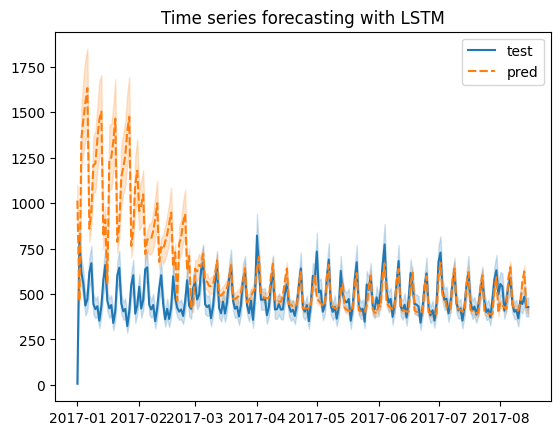

In [190]:
sns.lineplot(data = tmp[['test', 'pred']])
plt.title("Time series forecasting with LSTM")
plt.show()

## Linreg + XGBoost

In [192]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

In [193]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)

In [194]:
linreg = LinearRegression()
xgb = GradientBoostingRegressor()

In [283]:
def hybrid_prediction(X_sub, linreg = linreg, xgb = xgb, X_train = X_train, y_train = y_train) :

  linreg.fit(X_train, y_train)
  y_fit = linreg.predict(X_train)
  y_resid = y_train - y_fit
  y_sub_linreg = linreg.predict(X_sub)

  xgb.fit(X_train, y_resid)
  # y_fit_boosted = xgb.predict(X_train) + y_fit
  y_sub_boosted = xgb.predict(X_sub) + y_sub_linreg

  return y_sub_boosted

In [196]:
%%time
y_pred_hybrid = hybrid_prediction(X_test)

CPU times: user 5min 56s, sys: 2.23 s, total: 5min 58s
Wall time: 5min 59s


In [197]:
msle = mean_squared_log_error(abs(y_test), abs(y_pred_hybrid), squared=False)
print("Mean Squared Log Error:", msle)

Mean Squared Log Error: 0.009558609741931661


## Visualisation des résultats

In [198]:
dates_test = data[data['year'] == 2017]['date'].values
sales_test = pd.DataFrame(data[data['year'] == 2017]['sales'].values, index = dates_test)

In [211]:
y_pred_hybrid = scaler_y.inverse_transform(y_pred_hybrid.reshape(-1,1))

In [212]:
sales_pred = pd.DataFrame(y_pred_hybrid, index = dates_test)

In [213]:
tmp = pd.concat([sales_test, sales_pred], axis = 1)
tmp.columns = ['test', 'pred']

In [214]:
tmp

,test,pred
2017-01-01,0.000,65.103623
2017-01-01,0.000,82.313091
2017-01-01,0.000,82.313091
2017-01-01,0.000,694.230765
2017-01-01,0.000,36.587029
...,...,...
2017-08-15,438.133,1018.356091
2017-08-15,154.553,1018.356091
2017-08-15,2419.729,838.910142
2017-08-15,121.000,204.404196


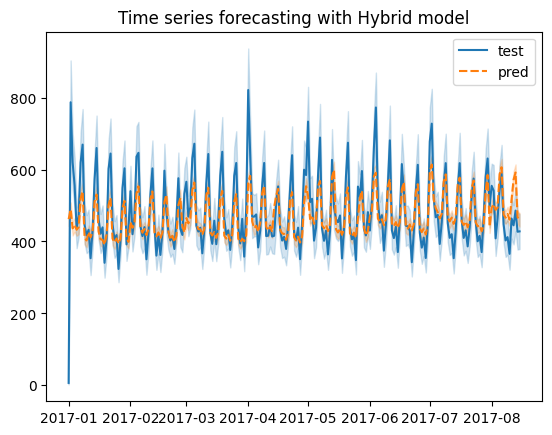

In [215]:
sns.lineplot(data = tmp[['test', 'pred']])
plt.title("Time series forecasting with Hybrid model")
plt.show()

# Feature importance

In [216]:
!pip install shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.8 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [217]:
%%time
best_model = xgb
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

CPU times: user 3min 12s, sys: 2.21 s, total: 3min 14s
Wall time: 3min 51s


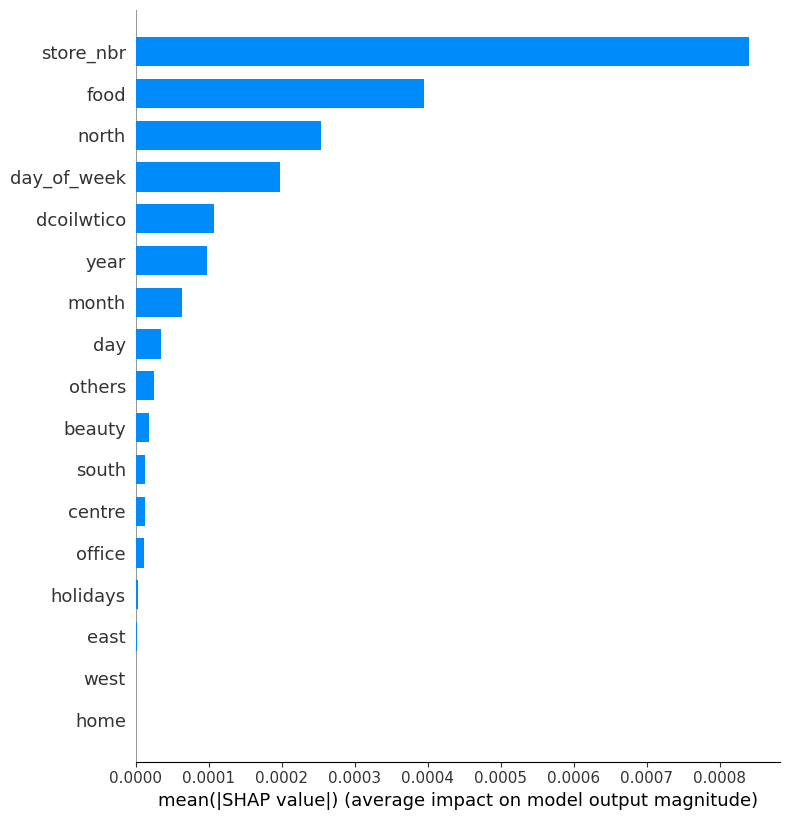

In [218]:
shap.summary_plot(shap_values, feature_names = features, plot_type='bar')

# Préparation du fichier test

In [252]:
test = pd.read_csv("test.csv")

In [253]:
test = pd.merge(test, stores)
test.shape

(28512, 9)

In [254]:
test = pd.merge(test, oil, how = "left")
test.shape

(28512, 10)

In [255]:
test.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'city', 'state',
       'type', 'cluster', 'dcoilwtico'],
      dtype='object')

In [256]:
test = test.drop(columns = {'onpromotion', 'type', 'cluster'})

In [257]:
test.head()

,id,date,store_nbr,family,city,state,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,Quito,Pichincha,46.8
1,3000889,2017-08-16,1,BABY CARE,Quito,Pichincha,46.8
2,3000890,2017-08-16,1,BEAUTY,Quito,Pichincha,46.8
3,3000891,2017-08-16,1,BEVERAGES,Quito,Pichincha,46.8
4,3000892,2017-08-16,1,BOOKS,Quito,Pichincha,46.8


In [258]:
test.shape

(28512, 7)

## Gestion des dates de vacances

In [259]:
test = pd.merge(test, holidays, on = "date", how = "left")
test.shape

(28512, 12)

In [260]:
test['holidays'] = False

In [261]:
%%time
test = test.apply(lambda x : find_holidays(x), axis = 1)

CPU times: user 2.2 s, sys: 29.5 ms, total: 2.23 s
Wall time: 2.23 s


In [262]:
test['holidays'].value_counts()

False    28446
True        66
Name: holidays, dtype: int64

In [263]:
test['holidays'] = test['holidays'].astype(int)

In [264]:
test.shape

(28512, 13)

In [265]:
test.drop(columns = {'city', 'type', 'locale', 'locale_name', 'description', 'transferred'}, inplace = True)

## One-hot encoding

### Family

In [266]:
test['family'].value_counts()

AUTOMOTIVE                    864
HOME APPLIANCES               864
SCHOOL AND OFFICE SUPPLIES    864
PRODUCE                       864
PREPARED FOODS                864
POULTRY                       864
PLAYERS AND ELECTRONICS       864
PET SUPPLIES                  864
PERSONAL CARE                 864
MEATS                         864
MAGAZINES                     864
LIQUOR,WINE,BEER              864
LINGERIE                      864
LAWN AND GARDEN               864
LADIESWEAR                    864
HOME CARE                     864
HOME AND KITCHEN II           864
BABY CARE                     864
HOME AND KITCHEN I            864
HARDWARE                      864
GROCERY II                    864
GROCERY I                     864
FROZEN FOODS                  864
EGGS                          864
DELI                          864
DAIRY                         864
CLEANING                      864
CELEBRATION                   864
BREAD/BAKERY                  864
BOOKS         

In [267]:
test['family_'] = None

In [268]:
test.loc[test['family'].isin(["PREPARED FOODS", "POULTRY", "MEATS", "LIQUOR,WINE,BEER", "GROCERY I", "GROCERY II", "FROZEN FOODS", "EGGS", "DAIRY", "BREAD/BAKERY", "BEVERAGES", "SEAFOOD"]), ['family_']] = "food"
test.loc[test['family'].isin(["HOME APPLIANCES", "LAWN AND GARDEN", "HOME CARE", "HOME AND KITCHEN II", "HOME AND KITCHEN I", "CLEANING"]), ['family_']] = "home"
test.loc[test['family'].isin(["PERSONAL CARE", "LINGERIE", "LADIESWEAR", "BABY CARE", "BEAUTY"]), ['family_']] = "beauty"
test.loc[test['family'].isin(["SCHOOL AND OFFICE SUPPLIES", "MAGAZINES", "BOOKS"]), ['family_']] = "office"
test.loc[test['family'].isin(["AUTOMOTIVE", "PLAYERS AND ELECTRONICS", "PET SUPPLIES", "HARDWARE", "DELI", "CELEBRATION", "PRODUCE"]), ['family_']] = "others"

In [269]:
test['family_'].value_counts()

food      10368
others     6048
home       5184
beauty     4320
office     2592
Name: family_, dtype: int64

In [270]:
test = pd.concat([test, pd.get_dummies(test['family_'])], axis = 1)
#test.drop(columns = {'family', 'family_'}, inplace = True)

### State

In [271]:
test['state'].value_counts()

Pichincha                         10032
Guayas                             5808
Santo Domingo de los Tsachilas     1584
Azuay                              1584
Manabi                             1584
Cotopaxi                           1056
Tungurahua                         1056
Los Rios                           1056
El Oro                             1056
Chimborazo                          528
Imbabura                            528
Bolivar                             528
Pastaza                             528
Santa Elena                         528
Loja                                528
Esmeraldas                          528
Name: state, dtype: int64

In [272]:
test['state_'] = None

In [273]:
test.loc[test['state'].isin(["Esmeraldas", "Imbabura", "Pichincha", "Santo Domingo de los Tsachilas"]), ['state_']] = "north"
test.loc[test['state'].isin(["Pastaza"]), ['state_']] = "east"
test.loc[test['state'].isin(["Loja", "El Oro", "Azuay"]), ['state_']] = "south"
test.loc[test['state'].isin(["Manabi", "Santa Elena", "Guayas"]), ['state_']] = "west"
test.loc[test['state'].isin(["Tungurahua", "Chimborazo", "Los Rios", "Bolivar", "Cotopaxi"]), ['state_']] = "centre"

In [274]:
test['state_'].value_counts()

north     12672
west       7920
centre     4224
south      3168
east        528
Name: state_, dtype: int64

In [275]:
test = pd.concat([test, pd.get_dummies(test['state_'])], axis = 1)
#test.drop(columns = {'state', 'state_'}, inplace = True)

## Retravail de la date

In [276]:
%%time
test['date'] = test['date'].apply(pd.to_datetime)

CPU times: user 2.12 s, sys: 10.3 ms, total: 2.13 s
Wall time: 2.15 s


In [277]:
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.day_of_week
test['day_name'] = test['date'].dt.day_name()

## Valeurs manquantes

<Axes: >

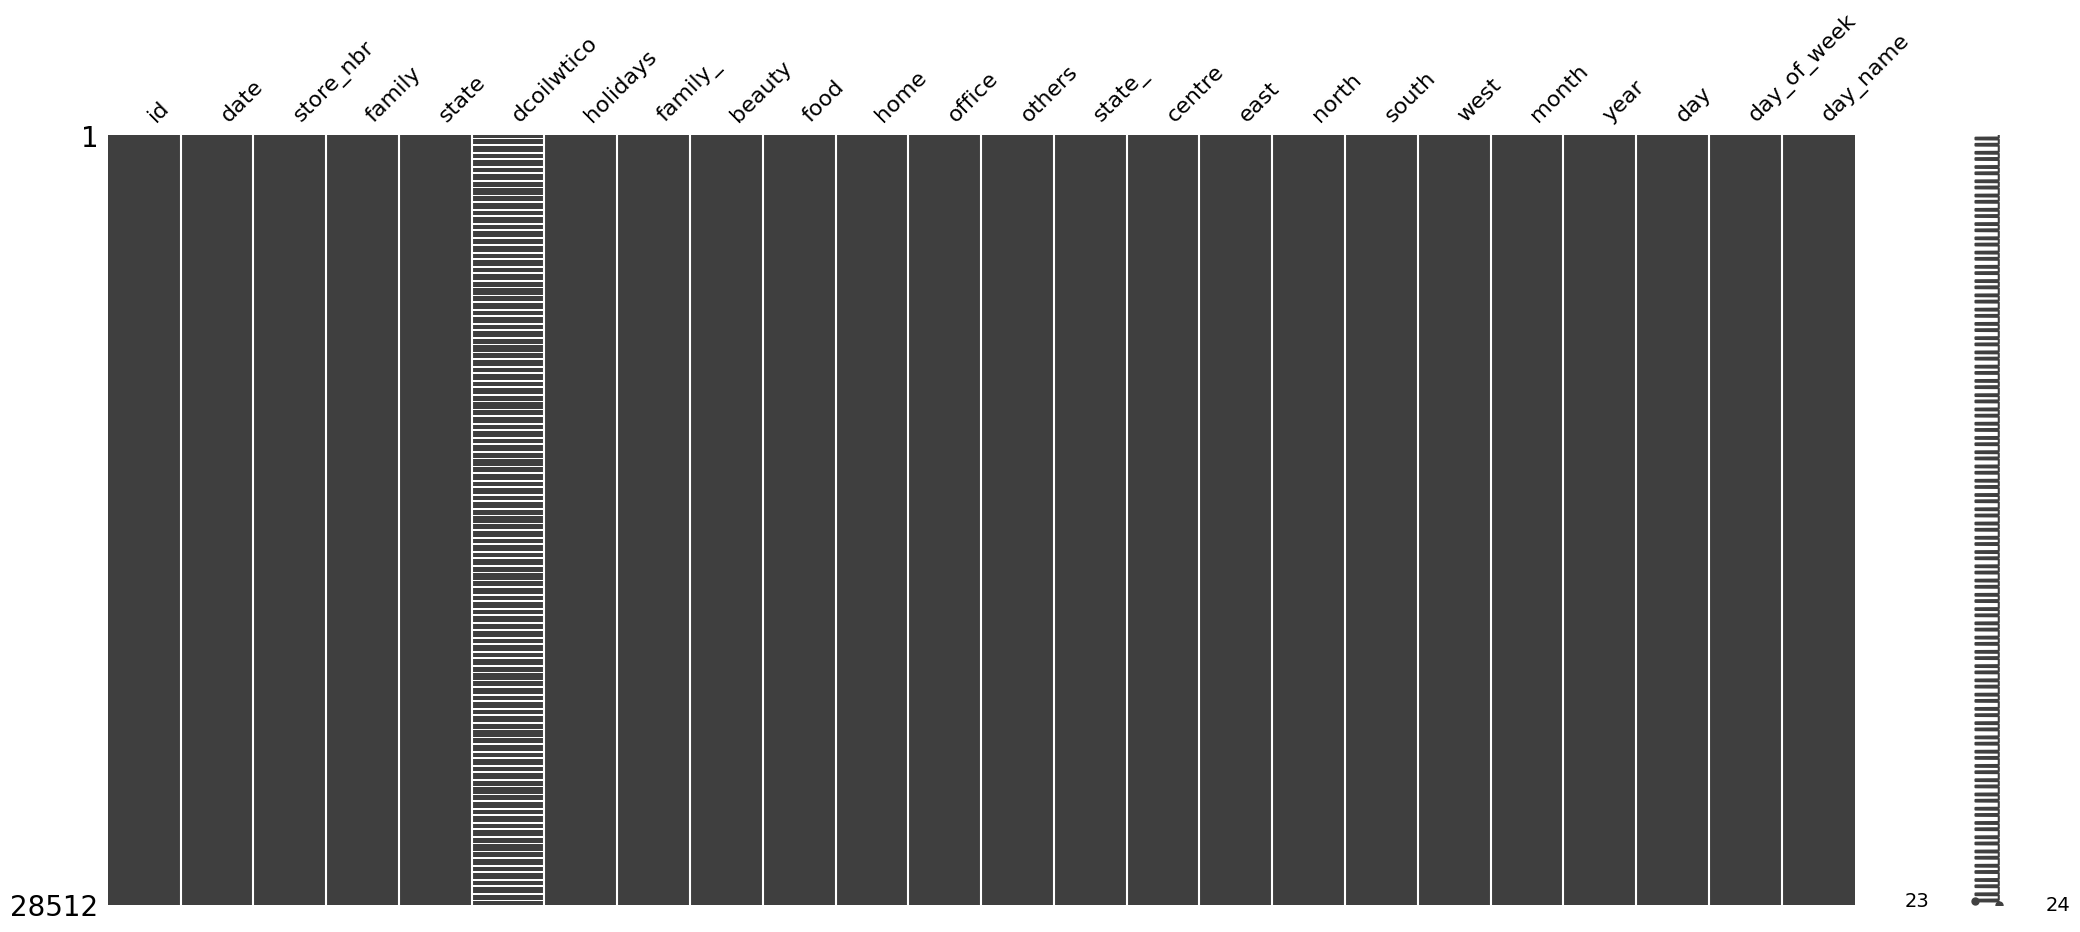

In [278]:
import missingno as msno
msno.matrix(test)

In [279]:
test['dcoilwtico'].fillna(test['dcoilwtico'].median(), inplace = True)

<Axes: >

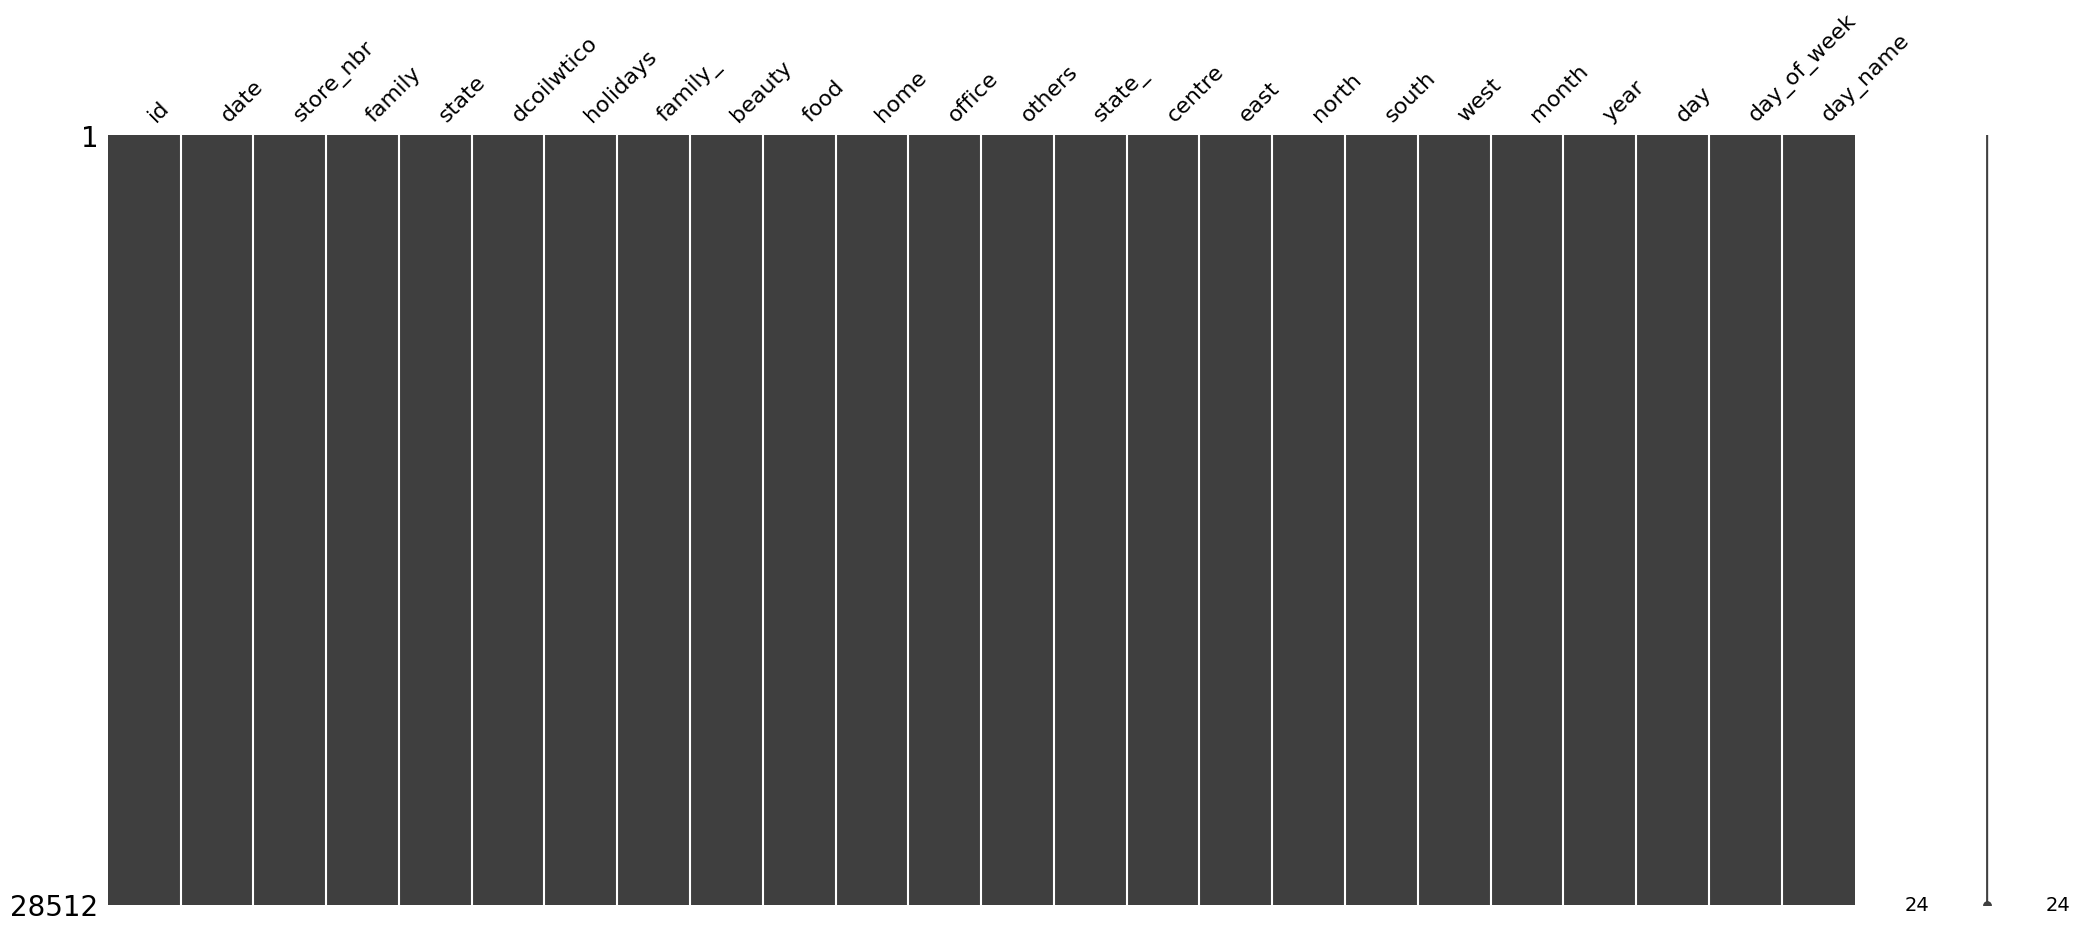

In [280]:
msno.matrix(test)

# ! Prédiction

In [291]:
X_sub = test[features]

In [293]:
X_sub = scaler_x.transform(X_sub)

In [317]:
y_sub = hybrid_prediction(X_sub)

In [318]:
y_sub = pd.DataFrame(scaler_y.inverse_transform(y_sub.reshape(-1,1)))

In [319]:
sample_submission['sales'] = y_sub

In [320]:
sample_submission

,id,sales
0,3000888,139.593664
1,3000889,156.803132
2,3000890,156.803132
3,3000891,772.815606
4,3000892,111.077070
...,...,...
28507,3029395,984.167877
28508,3029396,984.167877
28509,3029397,216.552934
28510,3029398,188.036340


In [315]:
sample_submission.to_csv("sample_submission_complete.csv", index = False)